In [1]:
#Import packages
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

In [2]:
from functions import *

In [3]:
# Directory containing the data
results_dir = 'C:/Users/ifiri/Documents/PROYECTOS/2024_claudia_alzheimer/results'
data_dir = 'C:/Users/ifiri/Documents/PROYECTOS/2024_claudia_alzheimer/precuneus_data'
os.chdir(data_dir)

# Load the time series data
ts_data, ts_data_struc, struc_names = process_data(data_dir)

# Window the data and compute the correlation matrices
structure_names = struc_names.to_list()
delta = 8 #number of time points on each window
corr_matrices = split_into_windows_and_compute_correlation(ts_data, delta)
print(corr_matrices.shape)  # Debería ser (62, 62, 57, 33)


Example plots and data exploration analysis

In [6]:
# Access a specific value
subject_id = 'Subject001'
timepoint = 1
structure = 'atlas.Precuneous'

specific_value = ts_data_struc.sel(subject=subject_id, timepoint=timepoint, struc=structure).item()
print(f"The value for {subject_id}, timepoint {timepoint}, structure '{structure}' is {specific_value}.")

The value for Subject001, timepoint 1, structure 'atlas.Precuneous' is 0.071413866083332.


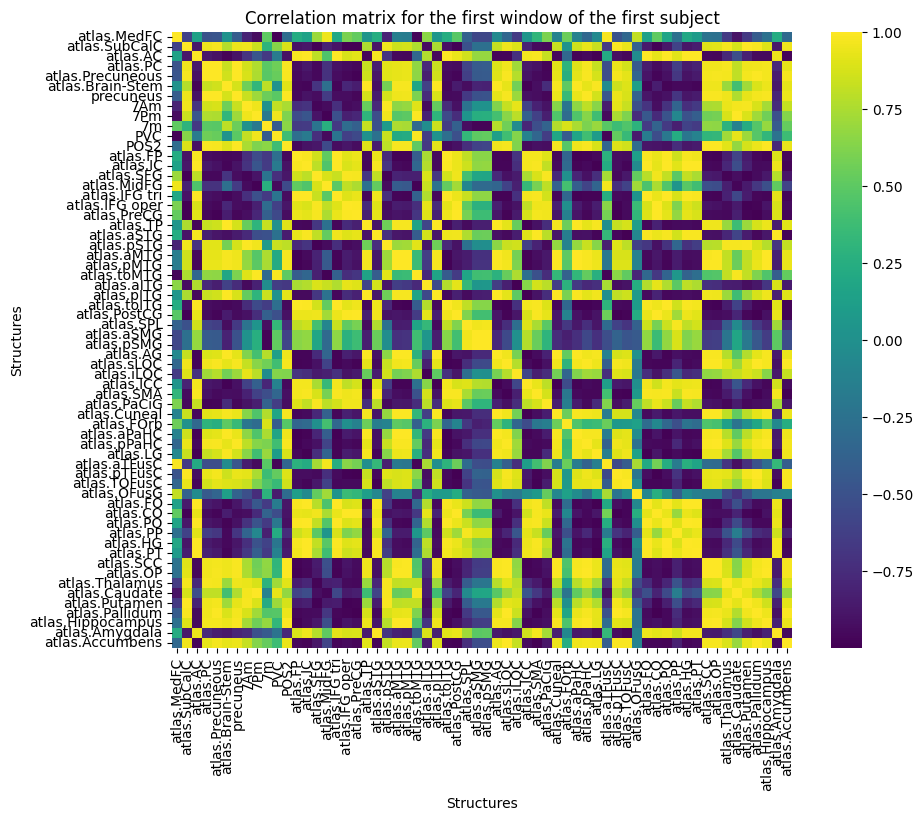

In [7]:
# plot a heatmap (sns) of a correlation matrix (e.g. the first one) from corr_df and add the x and y labels of the structure_names

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrices[:, :, 0, 0], xticklabels=structure_names, yticklabels=structure_names, cmap='viridis')
plt.xlabel('Structures')
plt.ylabel('Structures')
plt.title('Correlation matrix for the first window of the first subject')
plt.show()


IndexError: index 33 is out of bounds for axis 3 with size 33

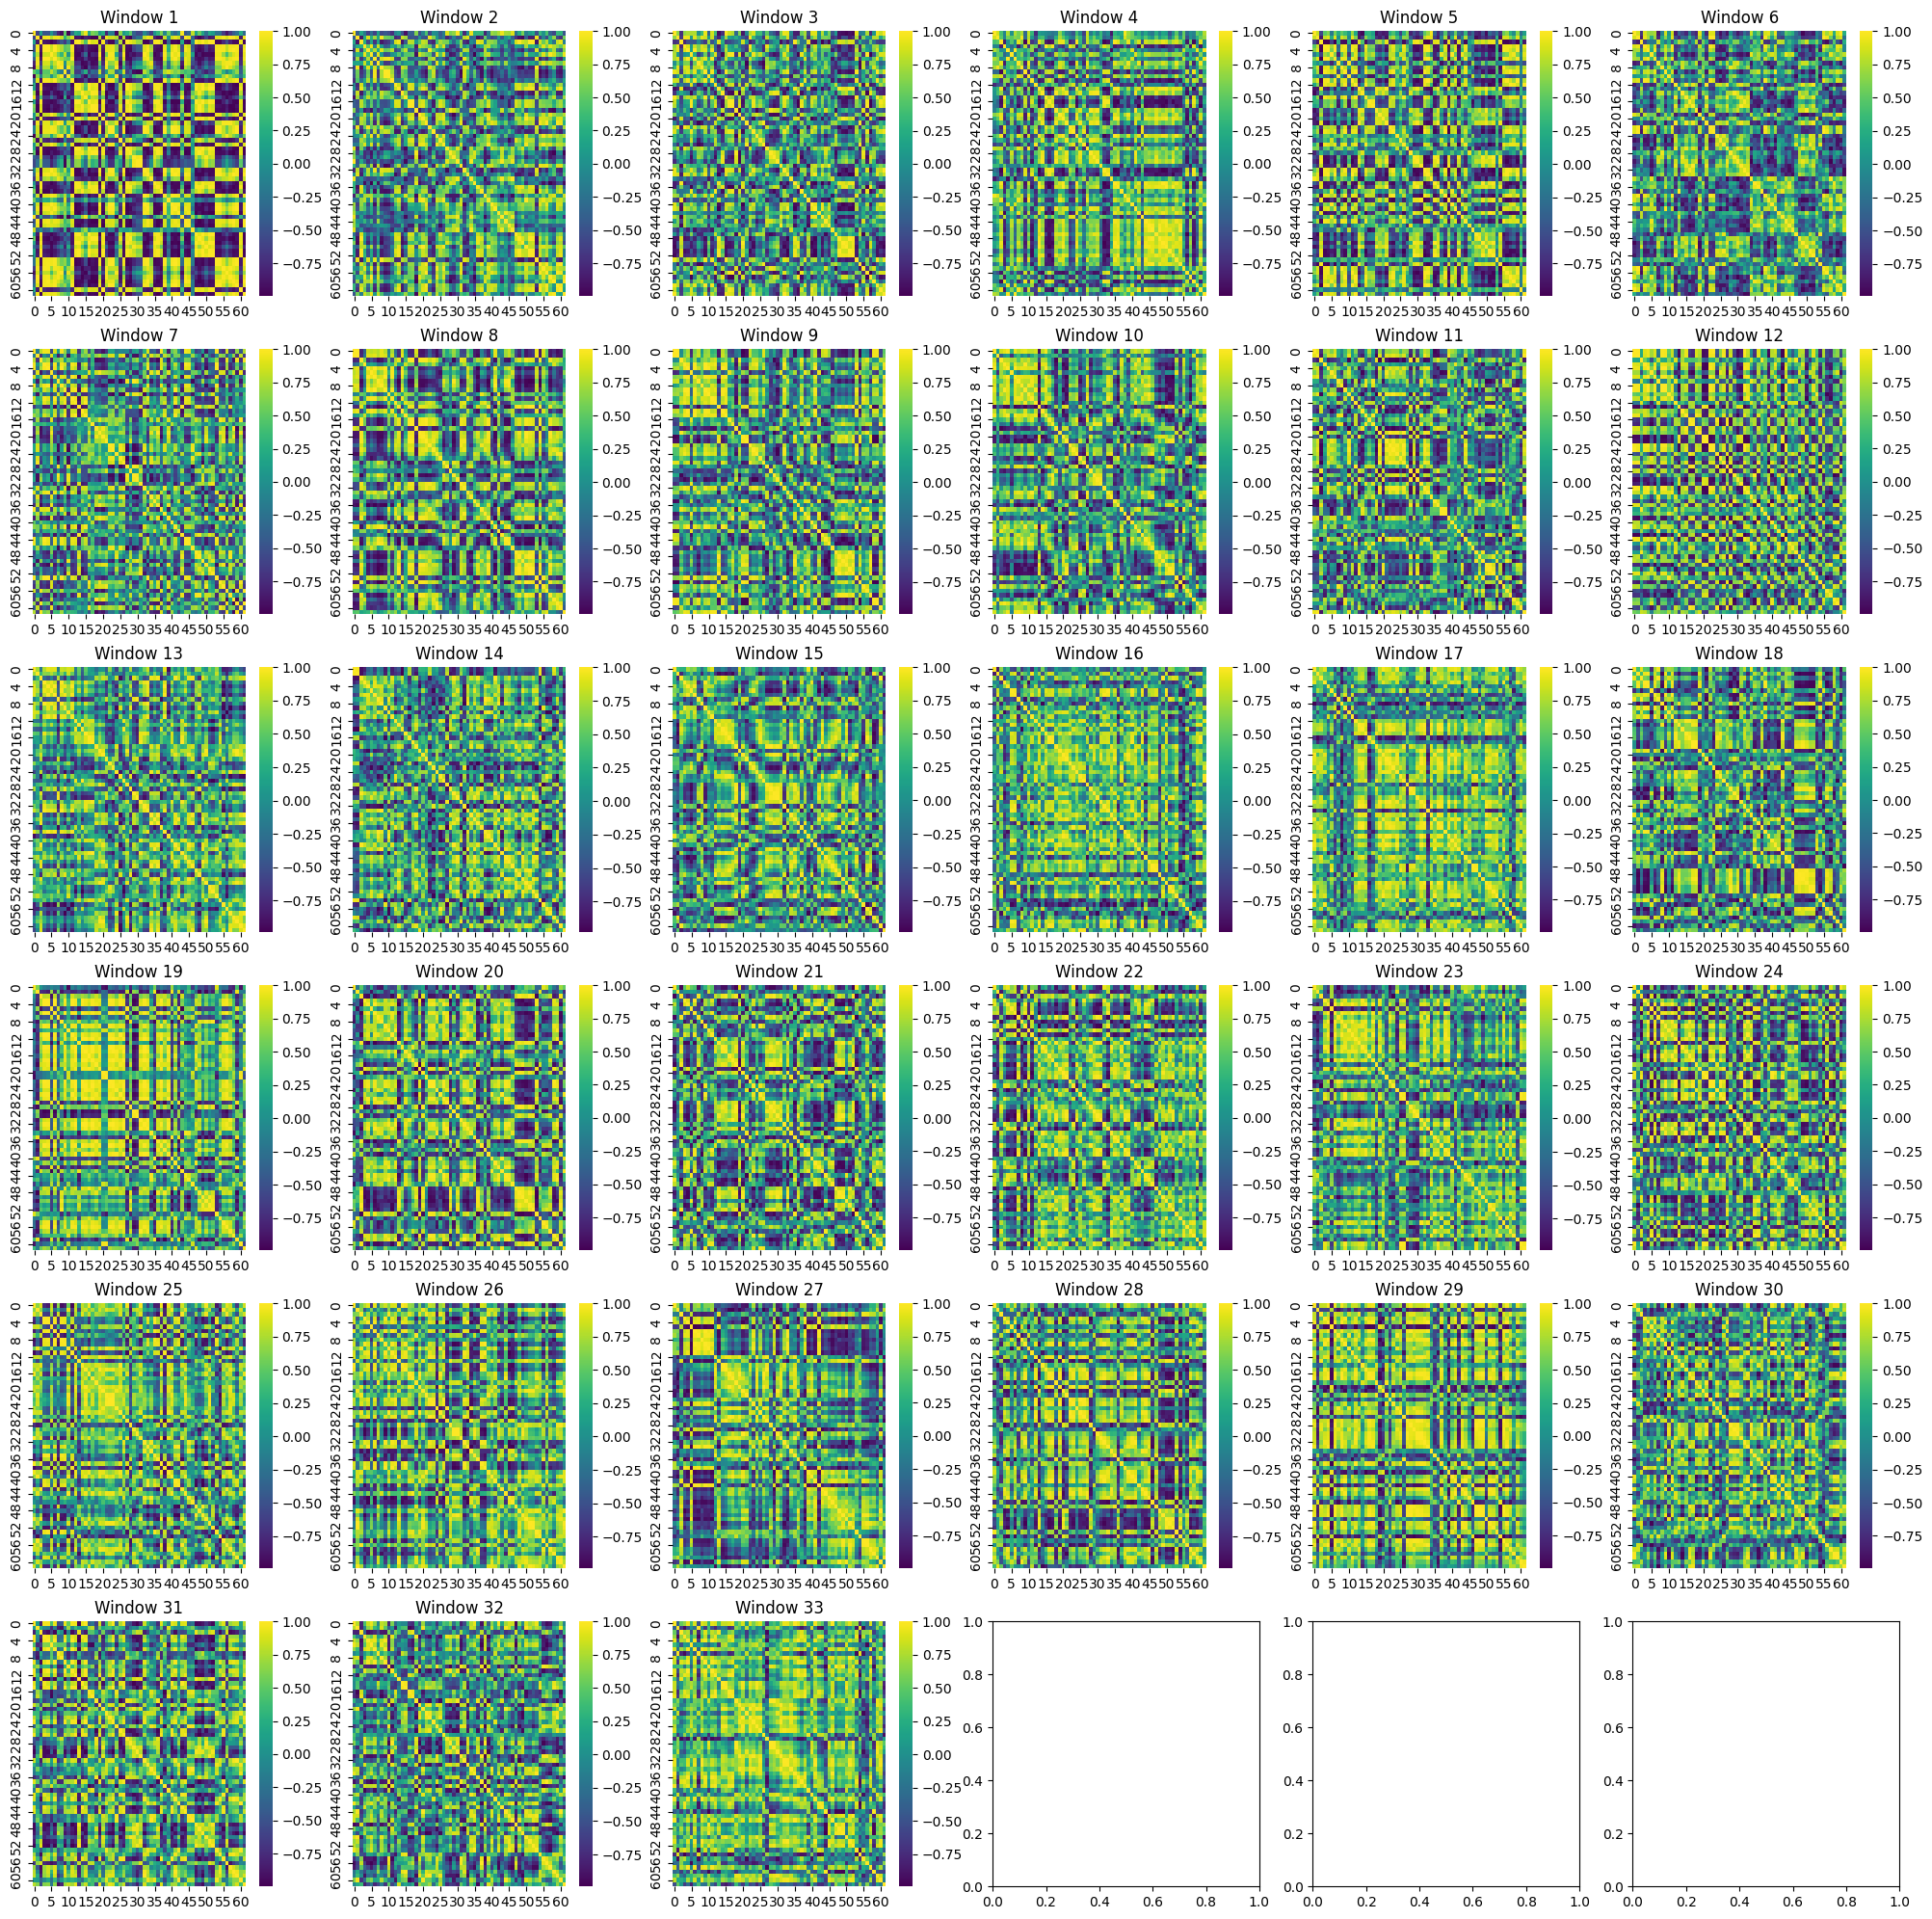

In [17]:
# Make a panel of figures with the correlation matrices for the first subject and all windows (33 windows) a grid of 6x6 figures

fig, axs = plt.subplots(6, 6, figsize=(25, 25))
for i, ax in enumerate(axs.flatten()):
    sns.heatmap(corr_matrices[:, :, 0, i], cmap='viridis', ax=ax)
    ax.set_title(f'Window {i+1}')



In [7]:
# Access a specific structure
structure = 'atlas.Precuneous'

# Select the data for the specified structure
specific_structure_data = ts_data_struc.sel(struc=structure)
print(f"Data for structure '{structure}':\n", specific_structure_data)

Data for structure 'atlas.Precuneous':
 <xarray.DataArray (subject: 57, timepoint: 264)> Size: 120kB
array([[ 0.09758886,  0.07141387,  0.0565578 , ..., -0.02199321,
        -0.00404194, -0.01686222],
       [ 0.10512089,  0.08963008,  0.07717143, ...,  0.00778223,
         0.04712694,  0.07404984],
       [-0.04572452, -0.03574234, -0.02808673, ...,  0.13245787,
         0.10361103,  0.03490225],
       ...,
       [ 0.02928875,  0.06612195,  0.08632254, ..., -0.30634507,
        -0.17869804, -0.09064747],
       [ 0.0247729 ,  0.00280089, -0.00887523, ...,  0.08721695,
         0.1701274 ,  0.20474611],
       [-0.01167093, -0.07840766, -0.12230891, ...,  0.27544822,
         0.3363033 ,  0.3879627 ]])
Coordinates:
  * subject    (subject) <U10 2kB 'Subject001' 'Subject002' ... 'Subject057'
  * timepoint  (timepoint) int32 1kB 0 1 2 3 4 5 6 ... 258 259 260 261 262 263
    struc      <U16 64B 'atlas.Precuneous'


INTER-PRECUNEUS ANALYSIS: 6 ANALYSIS IN TOTAL
(1) precuneus (total) with the rest
(2-6) 7Am, 7Pm, 7m, PVC and POS2 with the rest 

In [ ]:
# Fix the structure
structure = 'POS2'

In [72]:
# We will fix one structure and perfom the analysis
structure_index = structure_names.index(structure)

# Seleccionar todas las estructuras excepto la fijada
remaining_indices = [i for i in range(len(structure_names)) if i != structure_index]

# Seleccionar los datos correspondientes a la fila de la estructura fijada y las columnas restantes
corr_matrices_structure_rows = corr_matrices[remaining_indices,:, :, :]
corr_matrices_structure_col = corr_matrices_structure_rows[:,structure_index, :, :]
print(corr_matrices_structure_col[:,2,20]) # Debería ser un vector de 62 elementos. El elemento 6 (precuneus) debería tener valor de corr=1. La correlacion de una estructura consigo misma (6,6) es 1.

# I want to compute the euclidean distance between all pairs of 33 windows so that i obtain a 33x33 matrix for each subject. 
# I will have 57 subjects, so the final matrix will be 33x33x57.

norm_distances = compute_norm_distances(corr_matrices_structure_col)
print(norm_distances.shape)  # Debería ser (33, 33, 57)

# Flatten each subject distance matrix to obtain a vector per subject

flattened_distances = flatten_distance_matrices(norm_distances)
print(flattened_distances.shape)  # Debería ser (57, 1089)

# Mean distance per subject
mean_distances = np.mean(flattened_distances, axis=1)

# Save the mean distances to a CSV file in the main folder and include fixed structure name in the filename
filename = f'inter_analysis_mean_distances_{structure}.csv'
np.savetxt(os.path.join(results_dir,filename), mean_distances, delimiter=',')
print(f"Mean distances saved to '{filename}'.")

[ 0.96437553  0.64699714  0.32468577  0.79821969  0.91199566  0.54671374
  0.88268628 -0.31834589  0.60702189  0.94867279  0.80014396  0.61701416
 -0.26495224  0.30802517 -0.13278285  0.13982945 -0.90684527  0.76196572
  0.91059442  0.57472327  0.81488082  0.76802966  0.76002059  0.05811505
  0.92737029  0.78289874 -0.74792594  0.7986161   0.28957176 -0.28000365
  0.31846468  0.92928468  0.57149907  0.20821921 -0.24666614  0.44881915
  0.57807003  0.20226741 -0.34154044  0.73076213  0.2085839  -0.5397683
  0.67514348  0.84692662 -0.27474221 -0.38368118 -0.01021582  0.62066839
  0.85185104  0.49730217  0.68665397  0.79221604  0.07168808  0.47659141
 -0.50900982  0.17994935  0.02947685 -0.85802376  0.33759432  0.86271857
 -0.24573451]
(33, 33, 57)
(57, 1089)
Mean distances saved to 'inter_analysis_mean_distances_POS2.csv'.


INTRA-PRECUNEUS ANALYSIS: 1 IN TOTAL.
7Am, 7Pm, 7m, PCV and POS2 strucs between them

In [ ]:
# Fix the 5 structures and find the index of each one
strucs =  '7Am', '7Pm', '7m', 'PVC', 'POS2'

In [66]:
# We will fix one structure and perfom the analysis
structure_indices = [structure_names.index(s) for s in strucs]

# Select the data for the specified structure. The final matrix should be 5x5x57x33
corr_matrices_structure_row = corr_matrices[structure_indices, :, :, :]
corr_matrices_structure_col = corr_matrices_structure_row[:, structure_indices, :, :]
print(corr_matrices_structure_col.shape)  # Debe ser: (5,5,57,33)

# Flatten the intra-structure matrices to compute the norm distance between vectors and no between matrices
intra_size = corr_matrices_structure_col.shape[0]
subjects = corr_matrices_structure_col.shape[2]
windows = corr_matrices_structure_col.shape[3]
corr_matrices_structure_flat = corr_matrices_structure_col.reshape(intra_size*intra_size, subjects, windows)

# I want to compute the euclidean distance between all pairs of 33 windows so that i obtain a 33x33 matrix for each subject. 
# I will have 57 subjects, so the final matrix will be 33x33x57.

norm_distances = compute_norm_distances(corr_matrices_structure_flat)
print(norm_distances.shape)  # Debería ser (33, 33, 57)

# Flatten each subject distance matrix to obtain a vector per subject

flattened_distances = flatten_distance_matrices(norm_distances)
print(flattened_distances.shape)  # Debería ser (57, 1089)

# Mean distance per subject
mean_distances = np.mean(flattened_distances, axis=1)

# Save the mean distances to a CSV file in the main folder and include fixed structure name in the filename
filename = f'intra_analysis_mean_distances_5precuneus.csv'
np.savetxt(os.path.join(results_dir,filename), mean_distances, delimiter=',')
print(f"Mean distances saved to '{filename}'.")

(5, 5, 57, 33)
(33, 33, 57)
(57, 1089)
Mean distances saved to 'intra_analysis_mean_distances_5precuneus.csv'.
